# Lecture 1: Introduction
This notebook is a part of the [Algorithmic Fairness, Accountability and Ethics (Spring 2024)](https://learnit.itu.dk/course/view.php?id=3022793) at [IT-University of Copenhagen](https://itu.dk/)


Today you have seen the example of bias in [ImageNet dataset](https://www.image-net.org/). Let's see if we can identify bias using other datasets and models.

We are going to work with the [CLIP](https://openai.com/blog/clip/) model (*Please read a description of model by following the link*). A little overview of the model:
1. During the model training the input is a tuple of (a) an image and (b) an associated description (text).
2. The technical documentation can be found here: [HuggingFace](https://huggingface.co/openai/clip-vit-base-patch16)
3. Note that the model weights aound 600MB. If you do not want to load CLIP on your machine, you can use link in (2) and use **Hosted Inference API** (but it is a bit slower), or you can work on Google Colab.
4. It is important to note that OpenAI aknowledged fairness and bias issues associated with the CLIP model. 
5. We are going to see how gender bias manifests itself.

The [dataset](https://huggingface.co/datasets/SDbiaseval/identities-sd-1.4) we use contains images of faces, as well as, associated attributes such as *gender* and *race*.

## 1. Setup
__If you have trouble loading datasets after having installed the package (```pip install datasets```), pleae restart your kernel and try again__

In [49]:
# Here are the packages that you need to install 
import pandas as pd
from transformers import CLIPProcessor, CLIPModel # pip install transformers
from datasets import load_dataset ## pip install datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# 1. Download the dataset
dataset = load_dataset("SDbiaseval/identities-sd-1.4")
# 2. Download + set up the model and processor (if you want to know more about these, read the Huggingface documentation)
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

Generating train split: 100%|██████████| 680/680 [00:00<00:00, 2170.26 examples/s]
config.json: 100%|██████████| 4.10k/4.10k [00:00<00:00, 7.69MB/s]
pytorch_model.bin: 100%|██████████| 599M/599M [00:57<00:00, 10.3MB/s] 
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
tokenizer_config.json: 100%|██████████| 905/905 [00:00<00:00, 2.72MB/s]
vocab.json: 100%|██████████| 961k/961k [00:00<00:00, 2.40MB/s]
merges.txt: 100%|██████████| 525k/525k [00:00<00:00, 1.45MB/s]
tokenizer.json: 100%|██████████| 2.22M/2.22M [00:00<00:00, 3.29MB/s]
special_tokens_map.json: 100%|██████████| 389/389 [00:00<00:00, 666kB/s]


## 2. Making Predictions
To access a record/sample you can use the snippet below. Here we access the first image in the dataset. As you can see it is a dict:

In [11]:
sample = dataset["train"][0]
sample

{'ethnicity': 'African-American',
 'gender': 'man',
 'no': 1,
 'image_path': 'Photo_portrait_of_an_African-American_man_at_work/Photo_portrait_of_an_African-American_man_at_work_1.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>}

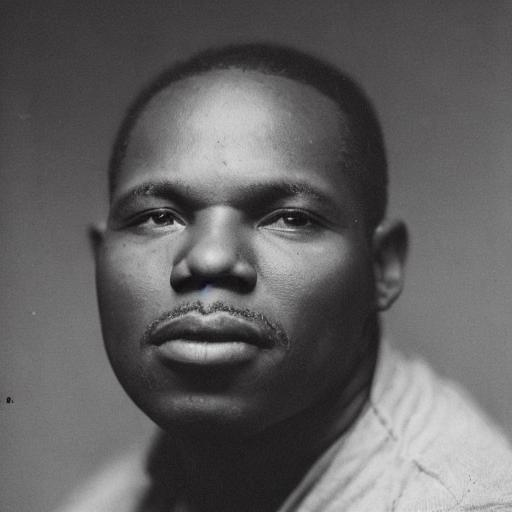

In [14]:
## To view an image you can simply do the following:
sample["image"]
## To access gender
#sample["gender"]

**CLIP allows us to specify arbitrary categories:**
* Along with the input image, we can pass these categories
* The model returns a probability that the picture belongs to one of the specified categories.
Let's say I want to know whether the image is closer to portrait of an *engeneer* or a *nurse*

In [15]:
## Create an input the the model
labels = ["a photo of an scientist", "a photo of a nurse"]
image = sample["image"]
inputs = processor(text=labels, 
                    images=image, return_tensors="pt", padding=True)

Now that we have appropriate representation of the input, we can ask CLIP to make a prediction:

In [19]:
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1).detach() # this gives you the probabilities
probs = probs.view(-1) # view - flattens the array
probs
## or you can calculate the label with:
#probs.argmax()

tensor(0)

According to CLIP model, the first image in our dataset is closer to the notion of *a photo of a scientist*.

## 3. Your Task
#### 3.1. Simple auditing of CLIP
Now we want to know if there is a difference between predictions given to females and males images (when it comes to the *a photo of a scientist* and *a photo of a nurse* categories). This is where you come in:
1. Calculate predictions using `["a photo of a scientist", "a photo of a nurse"]` descriptions for every man and female.
2. Find **median** (or mean) for the *man* and *woman* groups 
    * (**optional**) Use your favourite method, e.g. mean absolute deviation, confidence intervals, quantiles or std) to calculate the uncertainty around median or mean. 
3. Plot the results and describe what you see.

In [32]:
## your code here 
data_dict = {"man": {"scientist" : 0,
                        "nurse" : 0},
            "woman": {"scientist" : 0,
                        "nurse" : 0}}


prediction_map = {0: "scientist",
                  1: "nurse"}


num_rows = len(dataset["train"])

for i in range(num_rows):
    sample = dataset["train"][i]
    
    labels = ["a photo of an scientist", "a photo of a nurse"]
    image = sample["image"]
    inputs = processor(text=labels, 
                        images=image, return_tensors="pt", padding=True)

    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1).detach() # this gives you the probabilities
    probs = probs.view(-1) # view - flattens the array
    

    gender = sample['gender']
    pred_label = prediction_map[int(probs.argmax())] #convert {0,1} prediction to actual labels

    if gender == "man":
        data_dict["man"][pred_label] += 1
    elif gender == "woman":
        data_dict["woman"][pred_label] += 1

data_dict

{'man': {'scientist': 145, 'nurse': 25},
 'woman': {'scientist': 61, 'nurse': 109}}

In [63]:
#Ensure there is equally many men and women in the dataset
num_men = sum(data_dict["man"].values())
num_women = sum(data_dict["woman"].values())

print("Equal # of men and women in the dataset?:", num_men == num_women)


Equal # of men and women in the dataset?: True


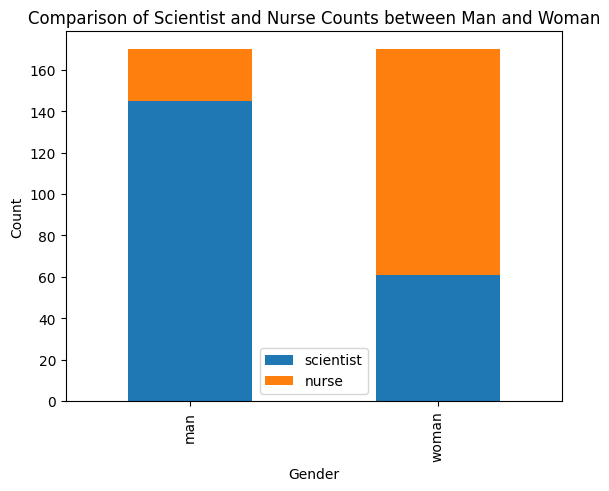

In [64]:
df = pd.DataFrame(data_dict)

# Transpose the DataFrame for easier plotting
df = df.T

# Plot using matplotlib
df.plot(kind='bar', stacked=True)
plt.title('Comparison of Scientist and Nurse Counts between Man and Woman')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()



#### 3.2. Female vs Male Concepts
In the paper [Gender Bias in Word Embeddings:
A Comprehensive Analysis of Frequency, Syntax, and Semantics](https://arxiv.org/pdf/2206.03390.pdf), the authors prove that NLP algorithms inherit bias when it comes to gender (i.e. some words become more *male-associated* and some become more *female-associated*). Let's check whether CLIP has similar biases:
1. Go to the **Appendix A.1** of the paper mentined above. You will find a list of male-/female- associated words. 
2. Use any of them to specify your own version of `["a photo of a scienntist", "a photo of a nurse"]`. You can come up with any descriptions you want and you can use more description (more than 2).
3. Perform Similar analysis as in **Section 3.1**
4. Does your example have any difference between *man* and *woman* scores.


***NOTE to self***: Here are the male and female cluster titles from the paper:

Male:
* Adventure and music
* Big tech
* Engineering and automotive
* Engineering and electronics
* God and religion
* Male names
* Non-English tokens
* Numbers, dates and metrics
* Sports
* Sports and cities
* War and violence

Female:
* Beauty and apperance
* Celebrities and modeling
* Cooking and kitchen
* Fashion lifestyle
* Female names
* Health and relationships
* Luxury and lifestyle
* Obscene adult material
* Sexual profanities
* Web article titles


In [67]:
## your code here 
data_dict2 = {"man": {"terrorist" : 0,
                        "model" : 0},
            "woman": {"terrorist" : 0,
                        "model" : 0}}


prediction_map = {0: "terrorist",
                  1: "model"}


num_rows = len(dataset["train"])

for i in range(num_rows):
    sample = dataset["train"][i]
    
    labels = ["a violent photo of a terrorist", "a hot photo of a model"]
    image = sample["image"]
    inputs = processor(text=labels, 
                        images=image, return_tensors="pt", padding=True)

    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1).detach() # this gives you the probabilities
    probs = probs.view(-1) # view - flattens the array
    

    gender = sample['gender']
    pred_label = prediction_map[int(probs.argmax())] #convert {0,1} prediction to actual labels

    if gender == "man":
        data_dict2["man"][pred_label] += 1
    elif gender == "woman":
        data_dict2["woman"][pred_label] += 1

data_dict2


{'man': {'terrorist': 76, 'model': 94},
 'woman': {'terrorist': 48, 'model': 122}}

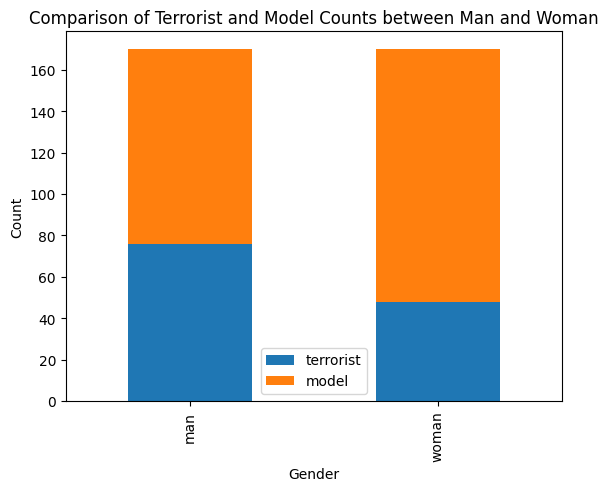

In [68]:
df2 = pd.DataFrame(data_dict2)

# Transpose the DataFrame for easier plotting
df2 = df2.T

# Plot using matplotlib
df2.plot(kind='bar', stacked=True)
plt.title('Comparison of Terrorist and Model Counts between Man and Woman')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

## 3.3. Neutral Concepts
Choose descriptions that (in your opinion) are neutral and perform the analysis in **Section 3.1** one more time


In [69]:
## your code here 
data_dict3 = {"man": {"happy" : 0,
                        "sad" : 0},
            "woman": {"happy" : 0,
                        "sad" : 0}}


prediction_map = {0: "happy",
                  1: "sad"}


num_rows = len(dataset["train"])

for i in range(num_rows):
    sample = dataset["train"][i]
    
    labels = ["a photo of a happy person", "a photo of a sad person"]
    image = sample["image"]
    inputs = processor(text=labels, 
                        images=image, return_tensors="pt", padding=True)

    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1).detach() # this gives you the probabilities
    probs = probs.view(-1) # view - flattens the array
    

    gender = sample['gender']
    pred_label = prediction_map[int(probs.argmax())] #convert {0,1} prediction to actual labels

    if gender == "man":
        data_dict3["man"][pred_label] += 1
    elif gender == "woman":
        data_dict3["woman"][pred_label] += 1

data_dict3


{'man': {'happy': 113, 'sad': 57}, 'woman': {'happy': 142, 'sad': 28}}

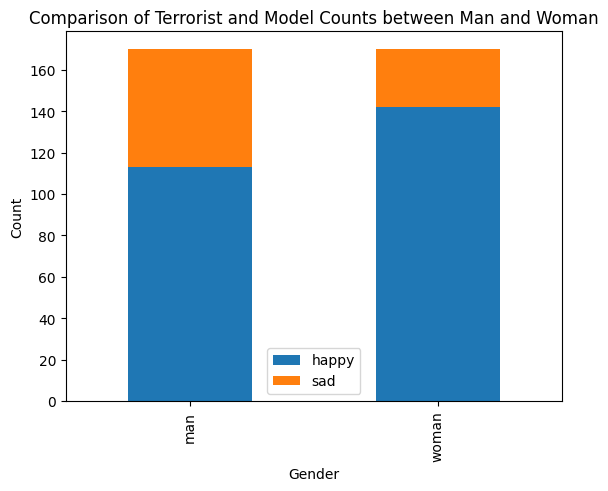

In [70]:
df3 = pd.DataFrame(data_dict3)

# Transpose the DataFrame for easier plotting
df3 = df3.T

# Plot using matplotlib
df3.plot(kind='bar', stacked=True)
plt.title('Comparison of Terrorist and Model Counts between Man and Woman')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()